In [1]:
import os
from pathlib import Path
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [2]:
# set Human SAO directory here
SAO_BASE_DIR_NAME = 'F:/Ionosonde/SAO_pick'
SAO_BASE_DIR = Path(SAO_BASE_DIR_NAME)

# set SBF directory here
SBF_BASE_DIR_NAME = 'F:/Ionosonde/SBF_mat'
SBF_BASE_DIR = Path(SBF_BASE_DIR_NAME)

# set ARTIST SAO directory here
SAO_AUTO_DIR_NAME = 'F:/Ionosonde/SAO_pick_ARTIST/'
SAO_AUTO_DIR = Path(SAO_AUTO_DIR_NAME)

In [3]:
counter = 0
# save list
gt_x_list = list()
gt_y_list = list()
auto_y_list = list()
for SAOs in SAO_BASE_DIR.glob('*.mat'):
    SAO_day = scipy.io.loadmat(str(SAOs))
    F2O = SAO_day['t_F2O']
    F1O = SAO_day['t_F1O']
    EO = SAO_day['t_EO']

    if os.path.exists(SAO_AUTO_DIR_NAME+SAOs.name[:-11]+'.SAO.mat'):
        pass
    else:
        continue
    # load SAO mat
    SAO_day_auto = scipy.io.loadmat(SAO_AUTO_DIR_NAME+SAOs.name[:-11]+'.SAO.mat')
    F2O_auto = SAO_day_auto['t_F2O']
    F1O_auto = SAO_day_auto['t_F1O']
    EO_auto = SAO_day_auto['t_EO']

    if len(F1O) < 1:
        continue
    for idx in range(len(SAO_day['TS'])-1):
        t_TS = SAO_day['TS'][idx+1]
        timecode = SAO_day['TS'][idx+1][2:6]+SAO_day['TS'][idx+1][9:19]
        t_mat_name = SBF_BASE_DIR_NAME + '/WU430_' + timecode + '.SBF.mat'
        
        if os.path.exists(t_mat_name):
            pass
        else:
            continue
        
        t_mat = scipy.io.loadmat(t_mat_name)

        amp_O = t_mat['AmplitudeO']
        amp_X = t_mat['AmplitudeX']
        MPA_O = t_mat['MPAO']
        MPA_X = t_mat['MPAX']
        Hs = float(t_mat['HeightStart'][0][0])
        Hd = float(t_mat['HeightStep'][0][0])
        Fs = float(t_mat['FrequencyStart'][0][0])
        Fd = float(t_mat['FrequencyStep'][0][0])

        input_array = np.zeros([np.shape(amp_O)[0],np.shape(amp_O)[1],3],dtype='uint8')
        input_array[:,:,0] = amp_O
        input_array[:,:,1] = amp_X

        if np.shape(input_array)[1] != np.shape(MPA_O)[1]:
            for jdx in range(np.shape(amp_O)[0]):
                input_array[jdx,:,2] = MPA_O[0,:np.shape(input_array)[1]]
        else:
            for jdx in range(np.shape(amp_O)[0]):
                input_array[jdx,:,2] = MPA_O

        print(timecode)

        t_mask = np.zeros([np.shape(amp_O)[0],np.shape(amp_O)[1],3],dtype='uint8')

        EO_length = int(len(EO[idx*2+1])/8)

        EO_freq = []
        EO_height = []
        for kdx in range(EO_length):
            #print(F2O[idx*2+1][kdx*8:(kdx+1)*8])
            try:
                if float(EO[idx*2+2][kdx*8:(kdx+1)*8]) > 3000:
                    continue
                EO_freq.append((float(EO[idx*2+1][kdx*8:(kdx+1)*8])-Fs)/Fd)
                EO_height.append((float(EO[idx*2+2][kdx*8:(kdx+1)*8])-Hs)/Hd)
            except:
                break
        EO_length = len(EO_freq)
        F1O_length = int(len(F1O[idx*2+1])/8)

        F1O_freq = []
        F1O_height = []
        for kdx in range(F1O_length):
            #print(F2O[idx*2+1][kdx*8:(kdx+1)*8])
            try:
                if float(F1O[idx*2+2][kdx*8:(kdx+1)*8]) > 3000:
                    continue
                F1O_freq.append((float(F1O[idx*2+1][kdx*8:(kdx+1)*8])-Fs)/Fd)
                F1O_height.append((float(F1O[idx*2+2][kdx*8:(kdx+1)*8])-Hs)/Hd)
            except:
                break
        F1O_length = len(F1O_freq)
        F2O_length = int(len(F2O[idx*2+1])/8)
        
        F2O_freq = []
        F2O_height = []
        for kdx in range(F2O_length):
            #print(F2O[idx*2+1][kdx*8:(kdx+1)*8])
            try:
                if float(F2O[idx*2+2][kdx*8:(kdx+1)*8]) > 3000:
                    continue
                F2O_freq.append((float(F2O[idx*2+1][kdx*8:(kdx+1)*8])-Fs)/Fd)
                F2O_height.append((float(F2O[idx*2+2][kdx*8:(kdx+1)*8])-Hs)/Hd)
            except:
                break
        F2O_length = len(F2O_freq)
        
        for kdx in range(len(EO_freq)-1):
            t_gap = int(EO_freq[kdx+1]) - int(EO_freq[kdx])
            t_k = int(EO_height[kdx+1]) - int(EO_height[kdx])
            t_mask[int(EO_height[kdx]),int(EO_freq[kdx]),0] = 1
            for mdx in range(t_gap):
                t_mask[int(EO_height[kdx]+(mdx+1)*t_k),int(EO_freq[kdx]+mdx+1),0] = 1

        for kdx in range(len(F1O_freq)-1):
            t_gap = int(F1O_freq[kdx+1]) - int(F1O_freq[kdx])
            t_k = int(F1O_height[kdx+1]) - int(F1O_height[kdx])
            t_mask[int(F1O_height[kdx]),int(F1O_freq[kdx]),1] = 1
            for mdx in range(t_gap):
                t_mask[int(F1O_height[kdx])+(mdx+1)*t_k,int(F1O_freq[kdx]+mdx+1),1] = 1


        for kdx in range(len(F2O_freq)-1):
            t_gap = int(F2O_freq[kdx+1]) - int(F2O_freq[kdx])
            t_k = int(F2O_height[kdx+1]) - int(F2O_height[kdx])
            t_mask[int(F2O_height[kdx]),int(F2O_freq[kdx]),2] = 1
            for mdx in range(t_gap):
                t_mask[int(F2O_height[kdx])+(mdx+1)*t_k,int(F2O_freq[kdx]+mdx+1),2] = 1

        #auto mask
        auto_mask = np.zeros([np.shape(amp_O)[0],np.shape(amp_O)[1],3],dtype='uint8')
        try:
            EO_length_auto = int(len(EO_auto[idx*2+1])/8)
        except:
            EO_length_auto = 0
        EO_freq = []
        EO_height = []
        for kdx in range(EO_length_auto):
            #print(F2O[idx*2+1][kdx*8:(kdx+1)*8])
            try:
                if float(EO_auto[idx*2+2][kdx*8:(kdx+1)*8]) > 3000:
                    continue
                EO_freq.append((float(EO_auto[idx*2+1][kdx*8:(kdx+1)*8])-Fs)/Fd)
                EO_height.append((float(EO_auto[idx*2+2][kdx*8:(kdx+1)*8])-Hs)/Hd)
            except:
                break
        EO_length_auto = len(EO_freq)

        try:
            F1O_length_auto = int(len(F1O_auto[idx*2+1])/8)
        except:
            F1O_length_auto = 0
            
        F1O_freq = []
        F1O_height = []
        for kdx in range(F1O_length_auto):
            #print(F2O[idx*2+1][kdx*8:(kdx+1)*8])
            try:
                if float(F1O_auto[idx*2+2][kdx*8:(kdx+1)*8]) > 3000:
                    continue
                F1O_freq.append((float(F1O_auto[idx*2+1][kdx*8:(kdx+1)*8])-Fs)/Fd)
                F1O_height.append((float(F1O_auto[idx*2+2][kdx*8:(kdx+1)*8])-Hs)/Hd)
            except:
                break
        F1O_length_auto = len(F1O_freq)

        try:
            F2O_length_auto = int(len(F2O_auto[idx*2+1])/8)
        except:
            F2O_length_auto = 0
        
        F2O_freq = []
        F2O_height = []
        for kdx in range(F2O_length_auto):
            #print(F2O[idx*2+1][kdx*8:(kdx+1)*8])
            try:
                if float(F2O_auto[idx*2+2][kdx*8:(kdx+1)*8]) > 3000:
                    continue
                F2O_freq.append((float(F2O_auto[idx*2+1][kdx*8:(kdx+1)*8])-Fs)/Fd)
                F2O_height.append((float(F2O_auto[idx*2+2][kdx*8:(kdx+1)*8])-Hs)/Hd)
            except:
                break
        F2O_length_auto = len(F2O_freq)
        
        for kdx in range(len(EO_freq)):
            auto_mask[int(EO_height[kdx]),int(EO_freq[kdx]),0] = 1.0
           
        for kdx in range(len(F1O_freq)):
            auto_mask[int(F1O_height[kdx]),int(F1O_freq[kdx]),1] = 1.0

        for kdx in range(len(F2O_freq)):
            auto_mask[int(F2O_height[kdx]),int(F2O_freq[kdx]),2] = 1.0       

        gt_x_list.append(input_array)
        gt_y_list.append(t_mask)
        auto_y_list.append(auto_mask)

20180201051500
20180201053000
20180201054500
20180201060000
20180201061500
20180201063000
20180201064500
20180201070000
20180201071500
20180201073000
20180201074500
20180201080000
20180201081500
20180201083000
20180201084500
20180201090000
20180201091500
20180201093000
20180201094500
20180201100000
20180201101500
20180201103000
20180201104500
20180201110000
20180201111500
20180201113000
20180201114500
20180201120000
20180201121500
20180201123000
20180201124500
20180201130000
20180201131500
20180201133000
20180201134500
20180201140000
20180201141500
20180201143000
20180201144500
20180201150000
20180201151500
20180201153000
20180201154500
20180201160000
20180201161500
20180201163000
20180201164500
20180201170000
20180201171500
20180201173000
20180201174500
20180201180000
20180201181500
20180201183000
20180201184500
20180201190000
20180201191500
20180201193000
20180201194500
20180201200000
20180201201500
20180201203000
20180201204500
20180201210000
20180201211500
20180201213000
2018020121

20180206224500
20180206230000
20180206231500
20180206233000
20180206234500
20180207000000
20180207001500
20180207003000
20180207004500
20180207010000
20180207011500
20180207013000
20180207014500
20180207020000
20180207021500
20180207023000
20180207024500
20180207030000
20180207031500
20180207033000
20180207034500
20180207040000
20180207041500
20180207043000
20180207044500
20180207050000
20180207051500
20180207053000
20180207054500
20180207060000
20180207061500
20180207063000
20180207064500
20180207070000
20180207071500
20180207073000
20180207074500
20180207080000
20180207081500
20180207083000
20180207084500
20180207090000
20180207091500
20180207093000
20180207094500
20180207100000
20180207101500
20180207103000
20180207104500
20180207110000
20180207111500
20180207113000
20180207114500
20180207120000
20180207121500
20180207123000
20180207124500
20180207130000
20180207131500
20180207133000
20180207134500
20180207140000
20180207141500
20180207143000
20180207144500
20180207150000
2018020715

20180212213000
20180212214500
20180212220000
20180212221500
20180212223000
20180212224500
20180212230000
20180212231500
20180212233000
20180212234500
20180213000000
20180213001500
20180213003000
20180213004500
20180213010000
20180213011500
20180213013000
20180213014500
20180213020000
20180213021500
20180213023000
20180213024500
20180213030000
20180213031500
20180213033000
20180213034500
20180213040000
20180213041500
20180213043000
20180213044500
20180213050000
20180213051500
20180213053000
20180213054500
20180213060000
20180213061500
20180213063000
20180213064500
20180213070000
20180213071500
20180213073000
20180213074500
20180213080000
20180213081500
20180213083000
20180213084500
20180213090000
20180213091500
20180213093000
20180213094500
20180213100000
20180213101500
20180213103000
20180213104500
20180213110000
20180213111500
20180213113000
20180213114500
20180213120000
20180213121500
20180213123000
20180213124500
20180213130000
20180213131500
20180213133000
20180213134500
2018021314

20180218164500
20180218170000
20180218171500
20180218173000
20180218174500
20180218180000
20180218181500
20180218183000
20180218184500
20180218190000
20180218191500
20180218193000
20180218194500
20180218200000
20180218201500
20180218203000
20180218204500
20180218210000
20180218211500
20180218213000
20180218214500
20180218220000
20180218221500
20180218223000
20180218224500
20180218230000
20180218231500
20180218233000
20180218234500
20180219000000
20180219001500
20180219003000
20180219004500
20180219010000
20180219011500
20180219013000
20180219014500
20180219020000
20180219021500
20180219023000
20180219024500
20180219030000
20180219031500
20180219033000
20180219034500
20180219040000
20180219041500
20180219043000
20180219044500
20180219050000
20180219051500
20180219053000
20180219054500
20180219060000
20180219061500
20180219063000
20180219064500
20180219070000
20180219071500
20180219073000
20180219074500
20180219080000
20180219081500
20180219083000
20180219084500
20180219090000
2018021909

20180224134500
20180224140000
20180224141500
20180224143000
20180224144500
20180224150000
20180224151500
20180224153000
20180224154500
20180224160000
20180224161500
20180224163000
20180224164500
20180224170000
20180224171500
20180224173000
20180224174500
20180224180000
20180224181500
20180224183000
20180224184500
20180224190000
20180224191500
20180224193000
20180224194500
20180224200000
20180224201500
20180224203000
20180224204500
20180224210000
20180224211500
20180224213000
20180224214500
20180224220000
20180224221500
20180224223000
20180224224500
20180224230000
20180224231500
20180224233000
20180224234500
20180225000000
20180225001500
20180225003000
20180225004500
20180225010000
20180225011500
20180225013000
20180225014500
20180225020000
20180225021500
20180225023000
20180225024500
20180225030000
20180225031500
20180225033000
20180225034500
20180225040000
20180225041500
20180225043000
20180225044500
20180225050000
20180225051500
20180225053000
20180225054500
20180225060000
2018022506

20180302101500
20180302103000
20180302104500
20180302110000
20180302111500
20180302113000
20180302114500
20180302120000
20180302121500
20180302123000
20180302124500
20180302130000
20180302131500
20180302133000
20180302134500
20180302140000
20180302141500
20180302143000
20180302144500
20180302150000
20180302151500
20180302153000
20180302154500
20180302160000
20180302161500
20180302163000
20180302164500
20180302170000
20180302171500
20180302173000
20180302174500
20180302180000
20180302181500
20180302183000
20180302184500
20180302190000
20180302191500
20180302193000
20180302194500
20180302200000
20180302201500
20180302203000
20180302204500
20180302210000
20180302211500
20180302213000
20180302214500
20180302220000
20180302221500
20180302223000
20180302224500
20180302230000
20180302231500
20180302233000
20180302234500
20180303000000
20180303001500
20180303003000
20180303004500
20180303010000
20180303011500
20180303013000
20180303014500
20180303020000
20180303021500
20180303023000
2018030302

20180308091500
20180308093000
20180308094500
20180308100000
20180308101500
20180308103000
20180308104500
20180308110000
20180308111500
20180308113000
20180308114500
20180308120000
20180308121500
20180308123000
20180308124500
20180308130000
20180308131500
20180308133000
20180308134500
20180308140000
20180308141500
20180308143000
20180308144500
20180308150000
20180308151500
20180308153000
20180308154500
20180308160000
20180308161500
20180308163000
20180308164500
20180308170000
20180308171500
20180308173000
20180308174500
20180308180000
20180308181500
20180308183000
20180308184500
20180308190000
20180308191500
20180308193000
20180308194500
20180308200000
20180308201500
20180308203000
20180308204500
20180308210000
20180308211500
20180308213000
20180308214500
20180308220000
20180308221500
20180308223000
20180308224500
20180308230000
20180308231500
20180308233000
20180308234500
20180309000000
20180309001500
20180309003000
20180309004500
20180309010000
20180309011500
20180309013000
2018030901

20180314020000
20180314021500
20180314023000
20180314024500
20180314030000
20180314031500
20180314033000
20180314034500
20180314040000
20180314041500
20180314043000
20180314044500
20180314050000
20180314051500
20180314053000
20180314054500
20180314060000
20180314061500
20180314063000
20180314064500
20180314070000
20180314071500
20180314073000
20180314074500
20180314080000
20180314081500
20180314083000
20180314084500
20180314090000
20180314091500
20180314093000
20180314094500
20180314100000
20180314101500
20180314103000
20180314104500
20180314110000
20180314111500
20180314113000
20180314114500
20180314120000
20180314121500
20180314123000
20180314124500
20180314130000
20180314131500
20180314133000
20180314134500
20180314140000
20180314141500
20180314143000
20180314144500
20180314150000
20180314151500
20180314153000
20180314154500
20180314160000
20180314161500
20180314163000
20180314164500
20180314170000
20180314171500
20180314173000
20180314174500
20180314180000
20180314181500
2018031418

20180319220000
20180319221500
20180319223000
20180319224500
20180319230000
20180319231500
20180319233000
20180319234500
20180320000000
20180320001500
20180320003000
20180320004500
20180320010000
20180320011500
20180320013000
20180320014500
20180320020000
20180320021500
20180320023000
20180320024500
20180320030000
20180320031500
20180320033000
20180320034500
20180320040000
20180320041500
20180320043000
20180320044500
20180320050000
20180320051500
20180320053000
20180320054500
20180320060000
20180320061500
20180320063000
20180320064500
20180320070000
20180320071500
20180320073000
20180320074500
20180320080000
20180320081500
20180320083000
20180320084500
20180320090000
20180320091500
20180320093000
20180320094500
20180320100000
20180320101500
20180320103000
20180320104500
20180320110000
20180320111500
20180320113000
20180320114500
20180320120000
20180320121500
20180320123000
20180320124500
20180320130000
20180320131500
20180320133000
20180320134500
20180320140000
20180320141500
2018032014

20180325171500
20180325173000
20180325174500
20180325180000
20180325181500
20180325183000
20180325184500
20180325190000
20180325191500
20180325193000
20180325194500
20180325200000
20180325201500
20180325203000
20180325204500
20180325210000
20180325211500
20180325213000
20180325214500
20180325220000
20180325221500
20180325223000
20180325224500
20180325230000
20180325231500
20180325233000
20180325234500
20180326000000
20180326001500
20180326003000
20180326004500
20180326010000
20180326011500
20180326013000
20180326014500
20180326020000
20180326021500
20180326023000
20180326024500
20180326030000
20180326031500
20180326033000
20180326034500
20180326040000
20180326041500
20180326043000
20180326044500
20180326050000
20180326051500
20180326053000
20180326054500
20180326060000
20180326061500
20180326063000
20180326064500
20180326070000
20180326071500
20180326073000
20180326074500
20180326080000
20180326081500
20180326083000
20180326084500
20180326090000
20180326091500
20180326093000
2018032609

20180331190000
20180331191500
20180331193000
20180331194500
20180331200000
20180331201500
20180331203000
20180331204500
20180331210000
20180331211500
20180331213000
20180331214500
20180331220000
20180331221500
20180331223000
20180331224500
20180331230000
20180331231500
20180331233000
20180331234500
20180401000000
20180401001500
20180401003000
20180401004500
20180401010000
20180401011500
20180401013000
20180401014500
20180401020000
20180401021500
20180401023000
20180401024500
20180401030000
20180401031500
20180401033000
20180401034500
20180401040000
20180401041500
20180401043000
20180401044500
20180401050000
20180401051500
20180401053000
20180401054500
20180401060000
20180401061500
20180401063000
20180401064500
20180401070000
20180401071500
20180401073000
20180401074500
20180401080000
20180401081500
20180401083000
20180401084500
20180401090000
20180401091500
20180401093000
20180401094500
20180401100000
20180401101500
20180401103000
20180401104500
20180401110000
20180401111500
2018040111

20180406114500
20180406120000
20180406121500
20180406123000
20180406124500
20180406130000
20180406131500
20180406133000
20180406134500
20180406140000
20180406141500
20180406143000
20180406144500
20180406150000
20180406151500
20180406153000
20180406154500
20180406160000
20180406161500
20180406163000
20180406164500
20180406170000
20180406171500
20180406173000
20180406174500
20180406180000
20180406181500
20180406183000
20180406184500
20180406190000
20180406191500
20180406193000
20180406194500
20180406200000
20180406201500
20180406203000
20180406204500
20180406210000
20180406211500
20180406213000
20180406214500
20180406220000
20180406221500
20180406223000
20180406224500
20180406230000
20180406231500
20180406233000
20180406234500
20180407000000
20180407001500
20180407003000
20180407004500
20180407010000
20180407011500
20180407013000
20180407014500
20180407020000
20180407021500
20180407023000
20180407024500
20180407030000
20180407031500
20180407033000
20180407034500
20180407040000
2018040704

20180417223000
20180417224500
20180417230000
20180417231500
20180417233000
20180417234500
20180418000000
20180418001500
20180418003000
20180418023000
20180418024500
20180418030000
20180418031500
20180418033000
20180418034500
20180418040000
20180418041500
20180418043000
20180418044500
20180418050000
20180418051500
20180418053000
20180418054500
20180418060000
20180418061500
20180418063000
20180418064500
20180418070000
20180418071500
20180418073000
20180418074500
20180418080000
20180418081500
20180418083000
20180418084500
20180418090000
20180418091500
20180418093000
20180418094500
20180418100000
20180418101500
20180418103000
20180418104500
20180418110000
20180418111500
20180418113000
20180418114500
20180418120000
20180418121500
20180418123000
20180418124500
20180418130000
20180418131500
20180418133000
20180418134500
20180418140000
20180418141500
20180418143000
20180418144500
20180418150000
20180418151500
20180418153000
20180418154500
20180418160000
20180418161500
20180418163000
2018041816

20180423171500
20180423173000
20180423174500
20180423180000
20180423181500
20180423183000
20180423184500
20180423190000
20180423191500
20180423193000
20180423194500
20180423200000
20180423201500
20180423203000
20180423204500
20180423210000
20180423211500
20180423213000
20180423214500
20180423220000
20180423221500
20180423223000
20180423224500
20180423230000
20180423231500
20180423233000
20180423234500
20180424000000
20180424001500
20180424003000
20180424004500
20180424010000
20180424011500
20180424013000
20180424014500
20180424020000
20180424021500
20180424023000
20180424024500
20180424030000
20180424031500
20180424033000
20180424034500
20180424040000
20180424041500
20180424043000
20180424044500
20180424050000
20180424051500
20180424053000
20180424054500
20180424060000
20180424061500
20180424063000
20180424073000
20180424074500
20180424080000
20180424081500
20180424083000
20180424084500
20180424090000
20180424091500
20180424093000
20180424094500
20180424100000
20180424101500
2018042410

20180429220000
20180429221500
20180429223000
20180429224500
20180429230000
20180429231500
20180429233000
20180429234500
20180430000000
20180430001500
20180430003000
20180430004500
20180430010000
20180430011500
20180430013000
20180430014500
20180430020000
20180430021500
20180430023000
20180430024500
20180430030000
20180430031500
20180430033000
20180430034500
20180430040000
20180430041500
20180430043000
20180430044500
20180430050000
20180430051500
20180430053000
20180430054500
20180430060000
20180430061500
20180430063000
20180430064500
20180430070000
20180430071500
20180430073000
20180430074500
20180430080000
20180430081500
20180430083000
20180430084500
20180430090000
20180430091500
20180430093000
20180430094500
20180430100000
20180430101500
20180430103000
20180430104500
20180430110000
20180430111500
20180430113000
20180430114500
20180430120000
20180430121500
20180430123000
20180430124500
20180430130000
20180430131500
20180430133000
20180430134500
20180430140000
20180430141500
2018043014

20180505190000
20180505191500
20180505193000
20180505194500
20180505200000
20180505201500
20180505203000
20180505204500
20180505210000
20180505211500
20180505213000
20180505214500
20180505220000
20180505221500
20180505223000
20180505224500
20180505230000
20180505231500
20180505233000
20180505234500
20180506000000
20180506001500
20180506003000
20180506004500
20180506010000
20180506011500
20180506013000
20180506014500
20180506020000
20180506021500
20180506023000
20180506024500
20180506030000
20180506031500
20180506033000
20180506034500
20180506040000
20180506041500
20180506043000
20180506044500
20180506050000
20180506051500
20180506053000
20180506054500
20180506060000
20180506061500
20180506063000
20180506064500
20180506070000
20180506071500
20180506073000
20180506074500
20180506080000
20180506081500
20180506083000
20180506084500
20180506090000
20180506091500
20180506093000
20180506094500
20180506100000
20180506101500
20180506103000
20180506104500
20180506110000
20180506111500
2018050611

20180511120000
20180511121500
20180511123000
20180511124500
20180511130000
20180511131500
20180511133000
20180511134500
20180511140000
20180511141500
20180511143000
20180511144500
20180511150000
20180511151500
20180511153000
20180511154500
20180511160000
20180511161500
20180511163000
20180511164500
20180511170000
20180511171500
20180511173000
20180511174500
20180511180000
20180511181500
20180511183000
20180511184500
20180511190000
20180511191500
20180511193000
20180511194500
20180511200000
20180511201500
20180511203000
20180511204500
20180511210000
20180511211500
20180511213000
20180512000000
20180512001500
20180512003000
20180512004500
20180512010000
20180512011500
20180512013000
20180512014500
20180512020000
20180512021500
20180512023000
20180512024500
20180512030000
20180512031500
20180512033000
20180512034500
20180512040000
20180512041500
20180512043000
20180512044500
20180512050000
20180512051500
20180512053000
20180512054500
20180512060000
20180512061500
20180512063000
2018051206

20180518091500
20180518093000
20180518094500
20180518100000
20180518101500
20180518103000
20180518104500
20180518110000
20180518111500
20180518113000
20180518114500
20180518120000
20180518121500
20180518123000
20180518124500
20180518130000
20180518131500
20180518133000
20180518134500
20180518140000
20180518141500
20180518143000
20180518144500
20180518150000
20180518151500
20180518153000
20180518154500
20180518160000
20180518161500
20180518163000
20180518164500
20180518170000
20180518171500
20180518173000
20180518174500
20180518180000
20180518181500
20180518183000
20180518184500
20180518190000
20180518191500
20180518193000
20180518194500
20180518200000
20180518201500
20180518203000
20180518204500
20180518210000
20180518211500
20180518213000
20180518214500
20180518220000
20180518221500
20180518223000
20180518224500
20180518230000
20180518231500
20180518233000
20180518234500
20180519000000
20180519001500
20180519003000
20180519004500
20180519010000
20180519011500
20180519013000
2018051901

20180524021500
20180524023000
20180524024500
20180524030000
20180524031500
20180524033000
20180524034500
20180524040000
20180524041500
20180524043000
20180524044500
20180524050000
20180524051500
20180524053000
20180524054500
20180524060000
20180524061500
20180524063000
20180524064500
20180524070000
20180524071500
20180524073000
20180524074500
20180524080000
20180524081500
20180524083000
20180524084500
20180524090000
20180524091500
20180524093000
20180524094500
20180524100000
20180524101500
20180524103000
20180524104500
20180524110000
20180524111500
20180524113000
20180524114500
20180524120000
20180524121500
20180524123000
20180524124500
20180524130000
20180524131500
20180524133000
20180524134500
20180524140000
20180524141500
20180524143000
20180524144500
20180524150000
20180524151500
20180524153000
20180524154500
20180524160000
20180524161500
20180524163000
20180524164500
20180524170000
20180524171500
20180524173000
20180524174500
20180524180000
20180524181500
20180524183000
2018052418

20180529193000
20180529194500
20180529200000
20180529201500
20180529203000
20180529204500
20180529210000
20180529211500
20180529213000
20180529214500
20180529220000
20180529221500
20180529223000
20180529224500
20180529230000
20180529231500
20180529233000
20180529234500
20180530000000
20180530001500
20180530003000
20180530004500
20180530010000
20180530011500
20180530013000
20180530014500
20180530020000
20180530021500
20180530023000
20180530024500
20180530030000
20180530031500
20180530033000
20180530034500
20180530040000
20180530041500
20180530043000
20180530044500
20180530050000
20180530051500
20180530053000
20180530054500
20180530060000
20180530061500
20180530063000
20180530064500
20180530070000
20180530071500
20180530073000
20180530074500
20180530080000
20180530081500
20180530083000
20180530084500
20180530090000
20180530091500
20180530093000
20180530094500
20180530100000
20180530101500
20180530103000
20180530104500
20180530110000
20180530111500
20180530113000
20180530114500
2018053012

20180604150000
20180604151500
20180604153000
20180604154500
20180604160000
20180604161500
20180604163000
20180604164500
20180604170000
20180604171500
20180604173000
20180604174500
20180604180000
20180604181500
20180604183000
20180604184500
20180604190000
20180604191500
20180604193000
20180604194500
20180604200000
20180604201500
20180604203000
20180604204500
20180604210000
20180604211500
20180604213000
20180604214500
20180604220000
20180604221500
20180604223000
20180604224500
20180604230000
20180604231500
20180604233000
20180604234500
20180605000000
20180605001500
20180605003000
20180605004500
20180605010000
20180605011500
20180605013000
20180605014500
20180605020000
20180605021500
20180605023000
20180605024500
20180605030000
20180605031500
20180605033000
20180605034500
20180605040000
20180605041500
20180605043000
20180605044500
20180605050000
20180605051500
20180605053000
20180605054500
20180605060000
20180605061500
20180605063000
20180605064500
20180605070000
20180605071500
2018060507

20180610114500
20180610120000
20180610121500
20180610123000
20180610124500
20180610130000
20180610131500
20180610133000
20180610134500
20180610140000
20180610141500
20180610143000
20180610144500
20180610150000
20180610151500
20180610153000
20180610154500
20180610160000
20180610161500
20180610163000
20180610164500
20180610170000
20180610171500
20180610173000
20180610174500
20180610180000
20180610181500
20180610183000
20180610184500
20180610190000
20180610191500
20180610193000
20180610194500
20180610200000
20180610201500
20180610203000
20180610204500
20180610210000
20180610211500
20180610213000
20180610214500
20180610220000
20180610221500
20180610223000
20180610224500
20180610230000
20180610231500
20180610233000
20180610234500
20180611000000
20180611001500
20180611003000
20180611004500
20180611010000
20180611011500
20180611013000
20180611014500
20180611020000
20180611021500
20180611023000
20180611024500
20180611030000
20180611031500
20180611033000
20180611034500
20180611040000
2018061104

20180616051500
20180616053000
20180616054500
20180616060000
20180616061500
20180616063000
20180616064500
20180616070000
20180616071500
20180616073000
20180616074500
20180616080000
20180616081500
20180616083000
20180616084500
20180616090000
20180616091500
20180616093000
20180616094500
20180616100000
20180616101500
20180616103000
20180616104500
20180616110000
20180616111500
20180616113000
20180616114500
20180616120000
20180616121500
20180616123000
20180616124500
20180616130000
20180616131500
20180616133000
20180616134500
20180616140000
20180616141500
20180616143000
20180616144500
20180616150000
20180616151500
20180616153000
20180616154500
20180616160000
20180616161500
20180616163000
20180616164500
20180616170000
20180616171500
20180616173000
20180616174500
20180616180000
20180616181500
20180616183000
20180616184500
20180616190000
20180616191500
20180616193000
20180616194500
20180616200000
20180616201500
20180616203000
20180616204500
20180616210000
20180616211500
20180616213000
2018061621

20180621233000
20180621234500
20180622000000
20180622001500
20180622003000
20180622004500
20180622010000
20180622011500
20180622013000
20180622014500
20180622020000
20180622021500
20180622023000
20180622024500
20180622030000
20180622031500
20180622033000
20180622034500
20180622040000
20180622041500
20180622043000
20180622044500
20180622050000
20180622051500
20180622053000
20180622054500
20180622060000
20180622061500
20180622063000
20180622064500
20180622070000
20180622071500
20180622073000
20180622074500
20180622080000
20180622081500
20180622083000
20180622084500
20180622090000
20180622091500
20180622093000
20180622094500
20180622100000
20180622101500
20180622103000
20180622104500
20180622110000
20180622111500
20180622113000
20180622114500
20180622120000
20180622121500
20180622123000
20180622124500
20180622130000
20180622131500
20180622133000
20180622134500
20180622140000
20180622141500
20180622143000
20180622144500
20180622150000
20180622151500
20180622153000
20180622154500
2018062216

20180627163000
20180627164500
20180627170000
20180627171500
20180627173000
20180627174500
20180627180000
20180627181500
20180627183000
20180627184500
20180627190000
20180627191500
20180627193000
20180627194500
20180627200000
20180627201500
20180627203000
20180627204500
20180627210000
20180627211500
20180627213000
20180627214500
20180627220000
20180627221500
20180627223000
20180627224500
20180627230000
20180627231500
20180627233000
20180627234500
20180628000000
20180628001500
20180628003000
20180628004500
20180628010000
20180628011500
20180628013000
20180628014500
20180628020000
20180628021500
20180628023000
20180628024500
20180628030000
20180628031500
20180628033000
20180628034500
20180628040000
20180628041500
20180628043000
20180628044500
20180628050000
20180628051500
20180628053000
20180628054500
20180628060000
20180628061500
20180628063000
20180628064500
20180628070000
20180628071500
20180628073000
20180628074500
20180628080000
20180628081500
20180628083000
20180628084500
2018062809

20180703104500
20180703110000
20180703111500
20180703113000
20180703114500
20180703120000
20180703121500
20180703123000
20180703124500
20180703130000
20180703131500
20180703133000
20180703134500
20180703140000
20180703141500
20180703143000
20180703144500
20180703150000
20180703151500
20180703153000
20180703154500
20180703160000
20180703161500
20180703163000
20180703164500
20180703170000
20180703171500
20180703173000
20180703174500
20180703180000
20180703181500
20180703183000
20180703184500
20180703190000
20180703191500
20180703193000
20180703194500
20180703200000
20180703201500
20180703203000
20180703204500
20180703210000
20180703211500
20180703213000
20180703214500
20180703220000
20180703221500
20180703223000
20180703224500
20180703230000
20180703231500
20180703233000
20180703234500
20180704000000
20180704001500
20180704003000
20180704004500
20180704010000
20180704011500
20180704013000
20180704014500
20180704020000
20180704021500
20180704023000
20180704024500
20180704030000
2018070403

20180709041500
20180709043000
20180709044500
20180709050000
20180709051500
20180709053000
20180709054500
20180709060000
20180709061500
20180709063000
20180709064500
20180709070000
20180709071500
20180709073000
20180709074500
20180709080000
20180709081500
20180709083000
20180709084500
20180709090000
20180709091500
20180709093000
20180709094500
20180709100000
20180709101500
20180709103000
20180709104500
20180709110000
20180709111500
20180709113000
20180709114500
20180709120000
20180709121500
20180709123000
20180709124500
20180709130000
20180709131500
20180709133000
20180709134500
20180709140000
20180709141500
20180709143000
20180709144500
20180709150000
20180709151500
20180709153000
20180709154500
20180709160000
20180709161500
20180709163000
20180709164500
20180709170000
20180709171500
20180709173000
20180709174500
20180709180000
20180709181500
20180709183000
20180709184500
20180709190000
20180709191500
20180709193000
20180709194500
20180709200000
20180709201500
20180709203000
2018070920

20180721050000
20180721051500
20180721053000
20180721054500
20180721060000
20180721061500
20180721063000
20180721064500
20180721070000
20180721071500
20180721073000
20180721074500
20180721080000
20180721081500
20180721083000
20180721084500
20180721090000
20180721091500
20180721093000
20180721094500
20180721100000
20180721101500
20180721103000
20180721104500
20180721110000
20180721111500
20180721113000
20180721114500
20180721120000
20180721121500
20180721123000
20180721124500
20180721130000
20180721131500
20180721133000
20180721134500
20180721140000
20180721141500
20180721143000
20180721144500
20180721150000
20180721151500
20180721153000
20180721154500
20180721160000
20180721161500
20180721163000
20180721164500
20180721170000
20180721171500
20180721173000
20180721174500
20180721180000
20180721181500
20180721183000
20180721184500
20180721190000
20180721191500
20180721193000
20180721194500
20180721200000
20180721201500
20180721203000
20180721204500
20180721210000
20180721211500
2018072121

20180727133000
20180727134500
20180727140000
20180727141500
20180727143000
20180727144500
20180727150000
20180727151500
20180727153000
20180727154500
20180727160000
20180727161500
20180727163000
20180727164500
20180727170000
20180727171500
20180727173000
20180727174500
20180727180000
20180727181500
20180727183000
20180727184500
20180727190000
20180727191500
20180727193000
20180727194500
20180727200000
20180727201500
20180727203000
20180727204500
20180727210000
20180727211500
20180727213000
20180727214500
20180727220000
20180727221500
20180727223000
20180727224500
20180727230000
20180727231500
20180727233000
20180727234500
20180729000000
20180729001500
20180729003000
20180729004500
20180729010000
20180729011500
20180729013000
20180729014500
20180729020000
20180729021500
20180729023000
20180729024500
20180729030000
20180729031500
20180729033000
20180729034500
20180729040000
20180729041500
20180729043000
20180729044500
20180729050000
20180729051500
20180729053000
20180729054500
2018072906

IndexError: index 506 is out of bounds for axis 0 with size 498

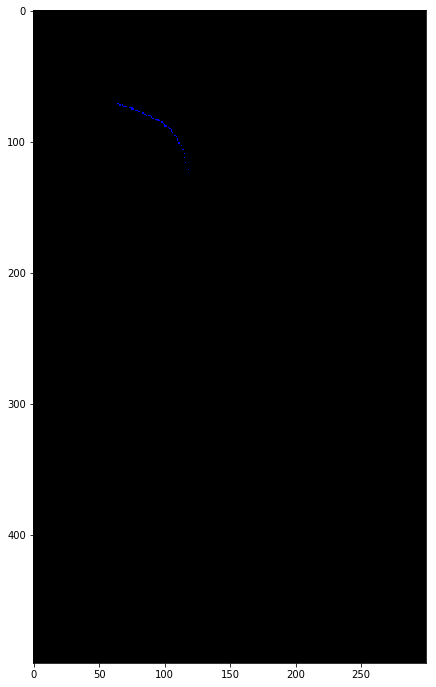

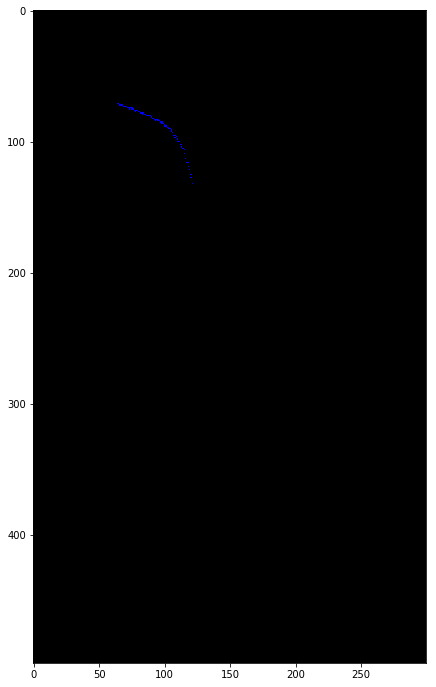

In [31]:
c_id = 7000
plt.figure(figsize=(12,12))
plt.imshow(auto_y_list[-1]*255)
plt.show()
plt.figure(figsize=(12,12))
plt.imshow(gt_y_list[-1]*255)
plt.show()

In [24]:
len(gt_x_list)

19910

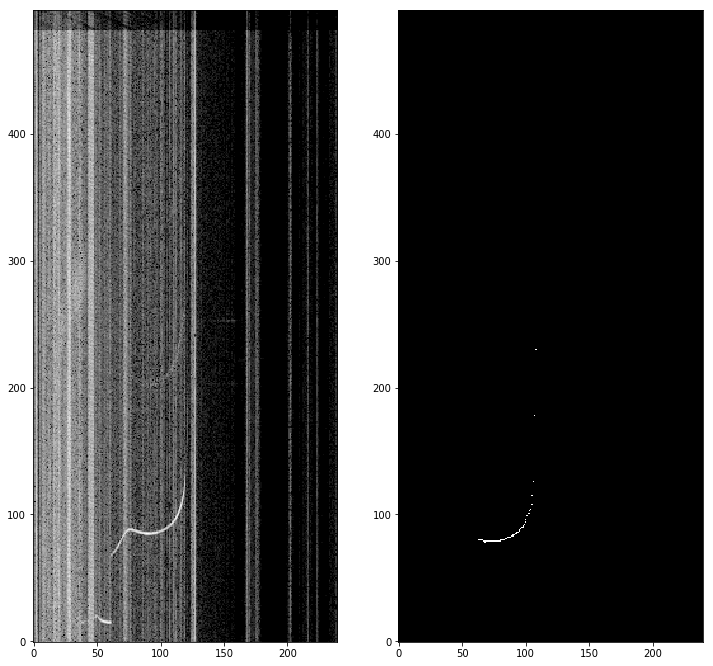

In [35]:
check_id = np.random.randint(low=0,high=len(gt_x_list))
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(gt_x_list[check_id][:,:,1],cmap='gray')
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(gt_y_list[check_id][:,:,2],cmap='gray')
plt.gca().invert_yaxis()
plt.show()
plt.close()

In [4]:
import pickle

In [ ]:
pickle.dump(gt_x_list,open('gt_x_list_uint8_1229.pickle','wb'))

In [ ]:
pickle.dump(gt_y_list,open('gt_y_list_uint8_1229.pickle','wb'))

In [ ]:
pickle.dump(auto_y_list,open('auto_y_list_uint8_1229.pickle','wb'))